# Problem-Specific Coordinate Generation for HyperNEAT Substrates

## Setup

The testing was done on a 16GB VRAM GPU with CUDA 12.8. VRAM usage is determined mainly by substrate and population size.

### Imports

This setup requires some dependencies, mainly TensorNEAT, JAX, numpy, matplotlib, NetworkX, scikit-learn and wandb for logging. Using a virtual environment (i.e. conda) is highly recommended. Python 3.10.18 was used in development and testing.

In [1]:
import jax
import numpy as np
import wandb
import matplotlib.pyplot as plt
from collections import defaultdict

from config import config
from tensorneat.algorithm.hyperneat import FullSubstrate

from pca_coor_generator import PCAanalyzer 
from sdl_coor_generator import SparseDictionaryAnalyzer
from fa_coor_generator import FactorAnalyzer
from manual_coor_generator import ManualInputMapper
from data_sampling import collect_random_policy_data, collect_trained_agent_policy_data
from brax_env import CustomBraxEnv
from custom_pipeline import CustomPipeline
from hidden_layers import HiddenLayerGenerator
from visualization import visualize_cppn, visualize_nn, display_plots_side_by_side
from utils import save_coordinates_to_csv, setup_folder_structure
from evol_algorithm import create_evol_algorithm

A quick setup of the folder structure to avoid errors further down the line.

In [2]:
OUTPUT_DIR = config["experiment"]["output_dir"]
setup_folder_structure(OUTPUT_DIR)

### Setup Environment

[Brax environments](https://github.com/google/brax/tree/main/brax/envs) are used for this experiment through the [TensorNEAT wrapper](https://github.com/EMI-Group/tensorneat/tree/main/src/tensorneat/problem/rl).

In [3]:
env_name = config["experiment"]["env_name"]
env_problem = CustomBraxEnv(
    env_name=env_name,
    backend=config["environment"]["backend"],
    brax_args=config["environment"]["brax_args"],
    max_step=config["environment"]["max_step"],
    repeat_times=config["environment"]["repeat_times"],
    obs_normalization=False,
    sample_episodes=16,
)
obs_size = env_problem.input_shape[0]
act_size = env_problem.output_shape[0]

print("env_problem.input_shape: ", env_problem.input_shape)

/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


env_problem.input_shape:  (27,)


## Data Sampling

Before we can apply data-driven approaches to the task of substrate generation, some data needs to be generated. This can either be done by generating random action or actually training an agent for a short period and then sampling from its action. Both data sampling methods are used for comparison.

### Data Sampling Method 1: Trained Agent

First, we train an number of agents for a few generations on a simple substrate for the sole purpose of sampling their actions.


In [ ]:
key = jax.random.PRNGKey(config["experiment"]["seed"]) # Use seed from config
num_trained_agent_sampling = config["data_sampling"]["num_agents_to_sample"]
all_trained_agent_data = []
for i in range(num_trained_agent_sampling):
    print(f"\nTraining and sampling agent #{i+1}/{num_trained_agent_sampling}")
    key, subkey = jax.random.split(key)
    trained_agent_data_run = collect_trained_agent_policy_data(
        env_problem=env_problem,
        key=subkey,
        num_steps=config["data_sampling"]["sampling_steps"],
        training_config=config["data_sampling"]["trained_agent_sampling"]
    )
    all_trained_agent_data.append(trained_agent_data_run)

combined_trained_agent_data = np.vstack(all_trained_agent_data)

print(f"Data collection complete. Combined data from {num_trained_agent_sampling} trained agents.")
print(f"Shape of each run's data: {all_trained_agent_data[0].shape}")
print(f"Shape of combined trained agents data: {combined_trained_agent_data.shape}")



Training and sampling agent #1/2

Starting Agent Training and Data Collection
Configuring and training the agent...
Query dimension for sampling:  4
initializing
initializing finished
start compile
compile finished, cost time: 23.763656s
Generation: 1, Cost time: 13415.10ms
 	fitness: valid cnt: 1000, max: 136.0574, min: -47.6826, mean: 12.4841, std: 19.1085

	node counts: max: 7, min: 5, mean: 6.28
 	conn counts: max: 7, min: 0, mean: 4.80
 	species: 20, [298, 51, 4, 59, 1, 1, 4, 7, 1, 1, 2, 4, 7, 1, 4, 138, 4, 4, 1, 408]

Generation: 2, Cost time: 12926.00ms
 	fitness: valid cnt: 1000, max: 117.2068, min: -50.6612, mean: 11.8649, std: 17.5914

	node counts: max: 8, min: 5, mean: 6.45
 	conn counts: max: 9, min: 0, mean: 4.71
 	species: 20, [99, 100, 17, 58, 17, 45, 29, 20, 26, 1, 73, 10, 11, 1, 16, 7, 6, 3, 2, 459]

Generation: 3, Cost time: 13028.79ms
 	fitness: valid cnt: 1000, max: 128.1772, min: -44.3394, mean: 11.2870, std: 18.9766

	node counts: max: 9, min: 5, mean: 6.73
 	co

2025-09-05 20:57:03.884430: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-05 20:57:03.884445: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-05 20:57:03.884449: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-05 20:57:03.884453: W external/xla/xla/service/gpu/au

Causal expert data collection finished.


Training and sampling agent #2/2

Starting Agent Training and Data Collection
Configuring and training the agent...
Query dimension for sampling:  4
initializing
initializing finished
start compile
compile finished, cost time: 22.982777s
Generation: 1, Cost time: 12947.72ms
 	fitness: valid cnt: 1000, max: 246.4237, min: -44.5355, mean: 14.3345, std: 22.3501

	node counts: max: 7, min: 5, mean: 6.25
 	conn counts: max: 7, min: 0, mean: 4.75
 	species: 20, [507, 7, 1, 2, 2, 2, 1, 2, 1, 3, 2, 1, 9, 68, 1, 1, 1, 1, 1, 387]

Generation: 2, Cost time: 13058.48ms
 	fitness: valid cnt: 1000, max: 209.4592, min: -85.8244, mean: 13.2055, std: 21.5957

	node counts: max: 8, min: 5, mean: 6.57
 	conn counts: max: 9, min: 0, mean: 4.83
 	species: 20, [102, 131, 43, 33, 35, 32, 30, 27, 28, 73, 19, 15, 10, 7, 4, 8, 6, 2, 3, 392]

Generation: 3, Cost time: 13067.91ms
 	fitness: valid cnt: 1000, max: 120.8579, min: -79.6261, mean: 14.3313, std: 21.7652

	node 

### Data Sampling Method 2: Random Policy

Now, we will sample data from the environment with a random action policy.

In [ ]:
key, random_key = jax.random.split(key)
random_data = collect_random_policy_data(env_problem, random_key, config["data_sampling"]["sampling_steps"])

Starting data collection for 1000 steps using a random policy...
Causal data collection finished.


In [ ]:
data_sources = {
    "trained": combined_trained_agent_data,
    "random": random_data
}

analysis_io_coors = defaultdict(lambda: defaultdict(dict))

## Data Analysis

Next, it's time to analyse the sampled data. The goal is to find correlations in the data which can be used to assign substrate coordinates. Again, different methods are used for comparison, namely Principal Component Analysis (PCA), Factor Analysis (FA) and Sparse Dictionary Learning (SDL). These methods will be applied to both data samples.

In this first step, the analysis methods will be used to produce input and output coordinates only. The hidden_layers are later generated.

### PCA Analysis

Principal Component Analysis (PCA) is commonly used for dimensionality reduction and using Singular Value Decomposition of the data to project it to a lower dimensional space. The [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) of PCA is used here.

Analyzing trained sampling data
Running PCA to find feature dimensions covering 75.0% of variance (with a hard limit of 8 dimensions)...
PCA found 4 dimensions needed for 75.0% variance.
Applying max limit. Final number of feature dimensions: 4
Added layering dimension. Final coordinate size: 5
PCA variance plot saved to: output/ant/data_analysis/pca_variance_75_trained.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_75_trained.png


Analyzing trained sampling data
Running PCA to find feature dimensions covering 100.0% of variance (with a hard limit of 8 dimensions)...
PCA found 1 dimensions needed for 100.0% variance.
Applying max limit. Final number of feature dimensions: 1
Added layering dimension. Final coordinate size: 2
PCA variance plot saved to: output/ant/data_analysis/pca_variance_100_trained.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_100_trained.png


Analyzing random sampling data
Running PCA to find feature

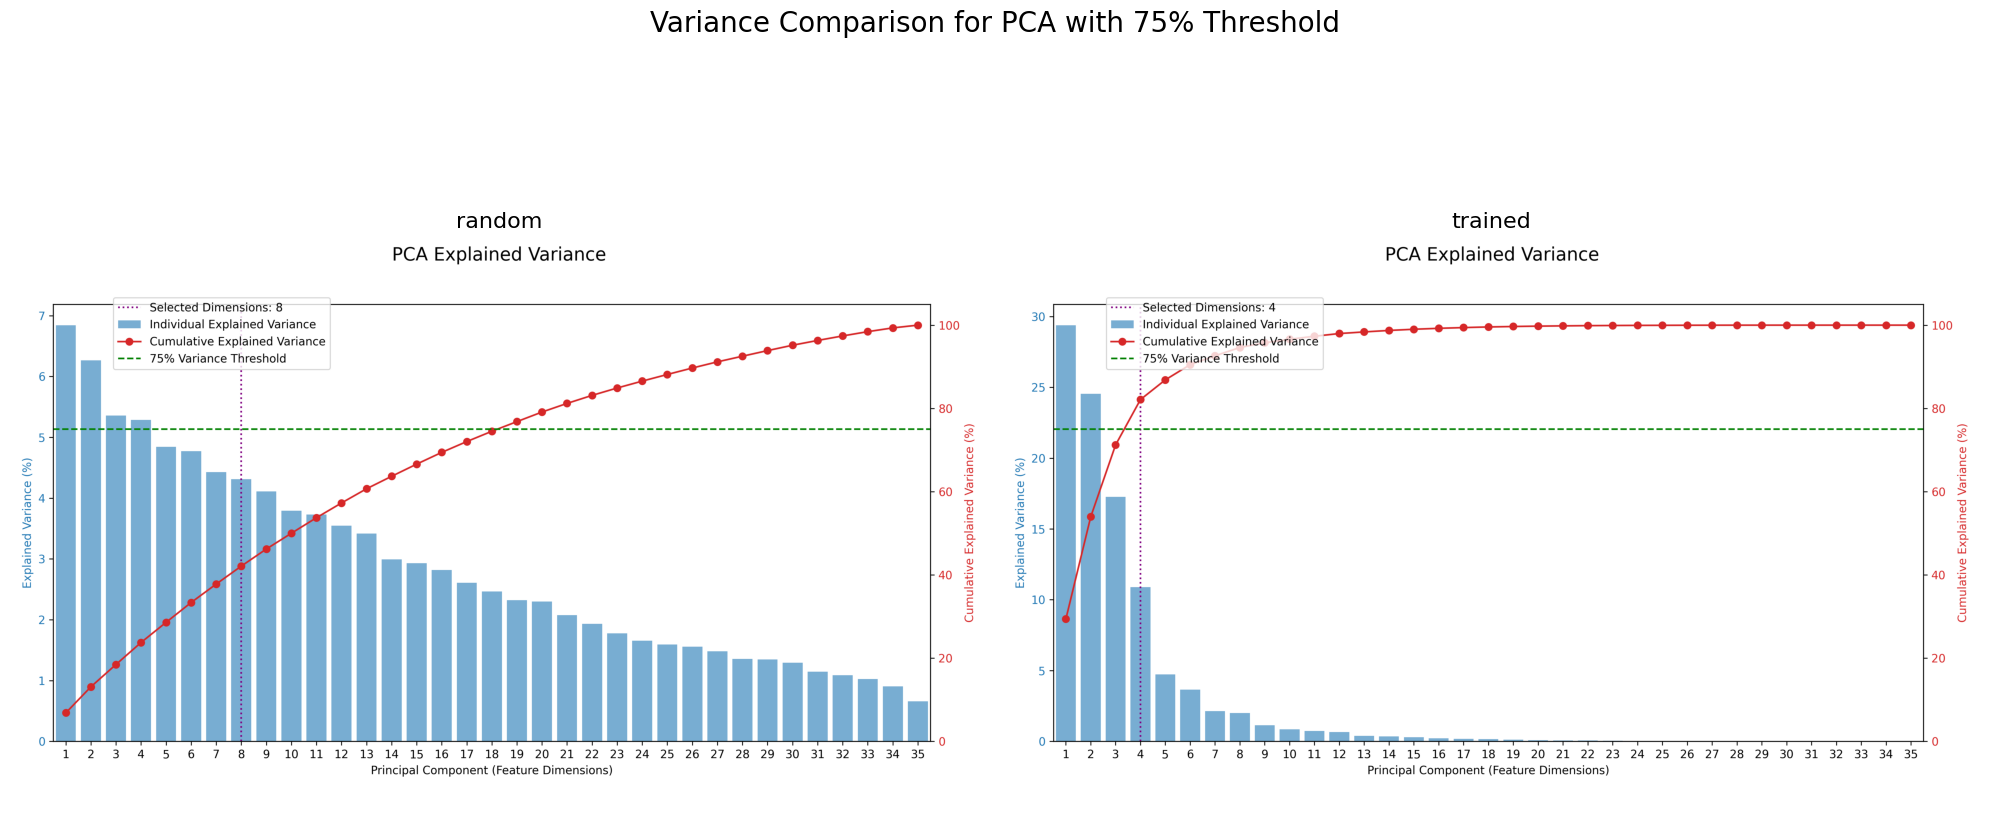

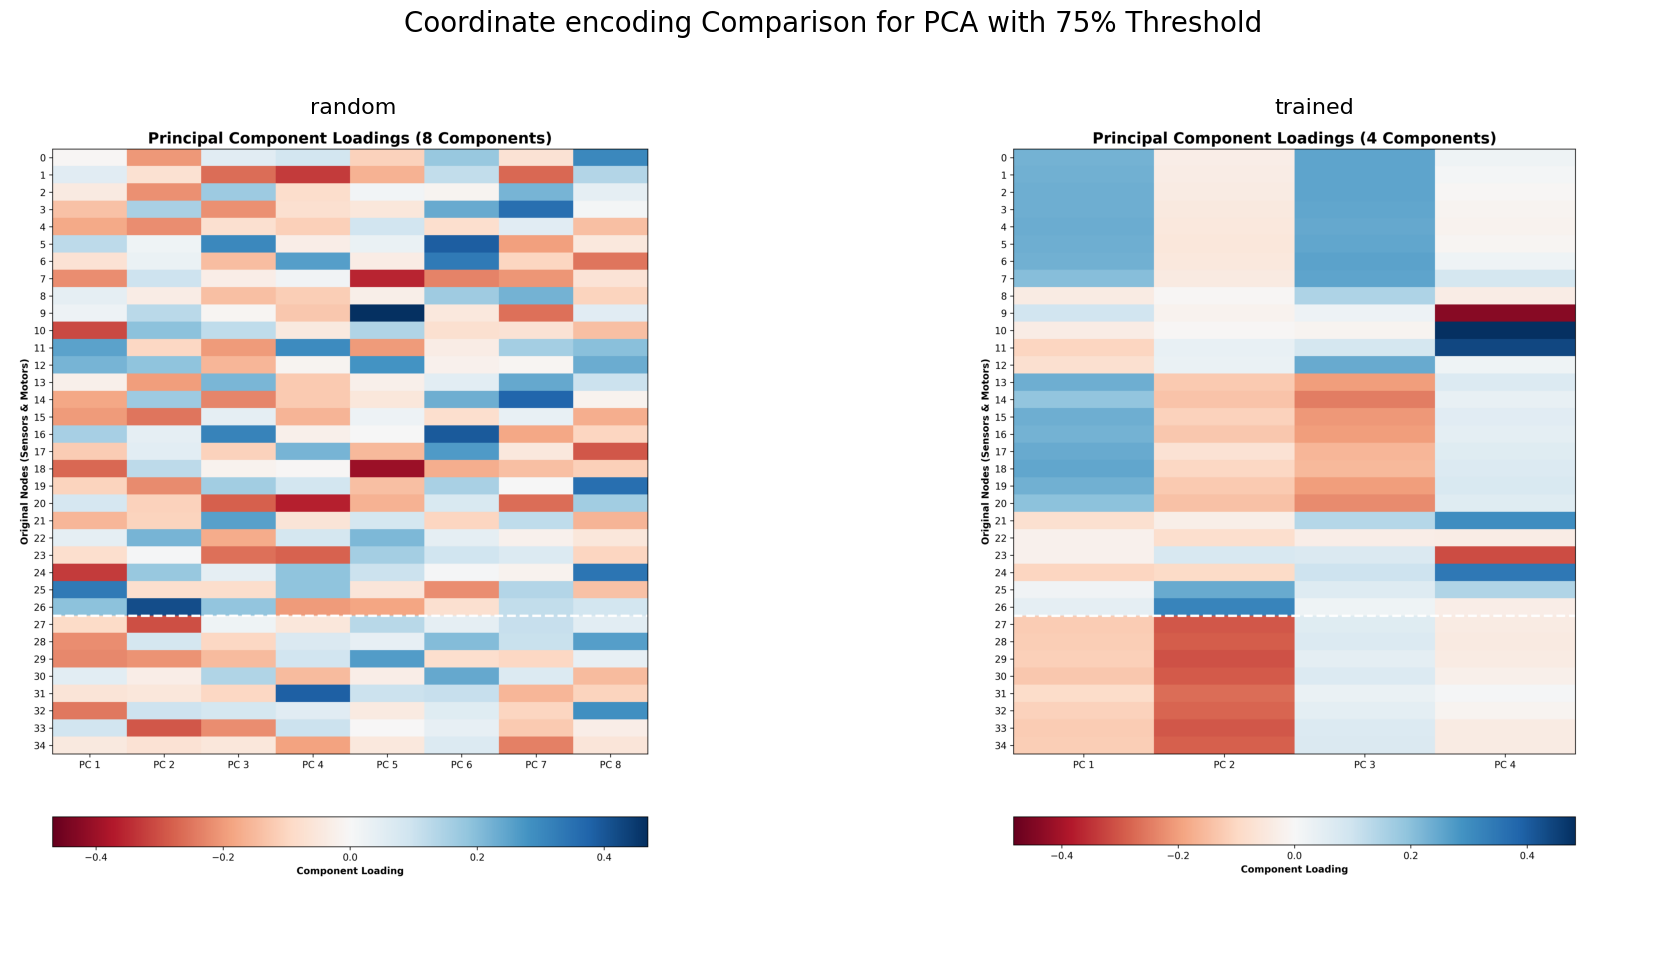

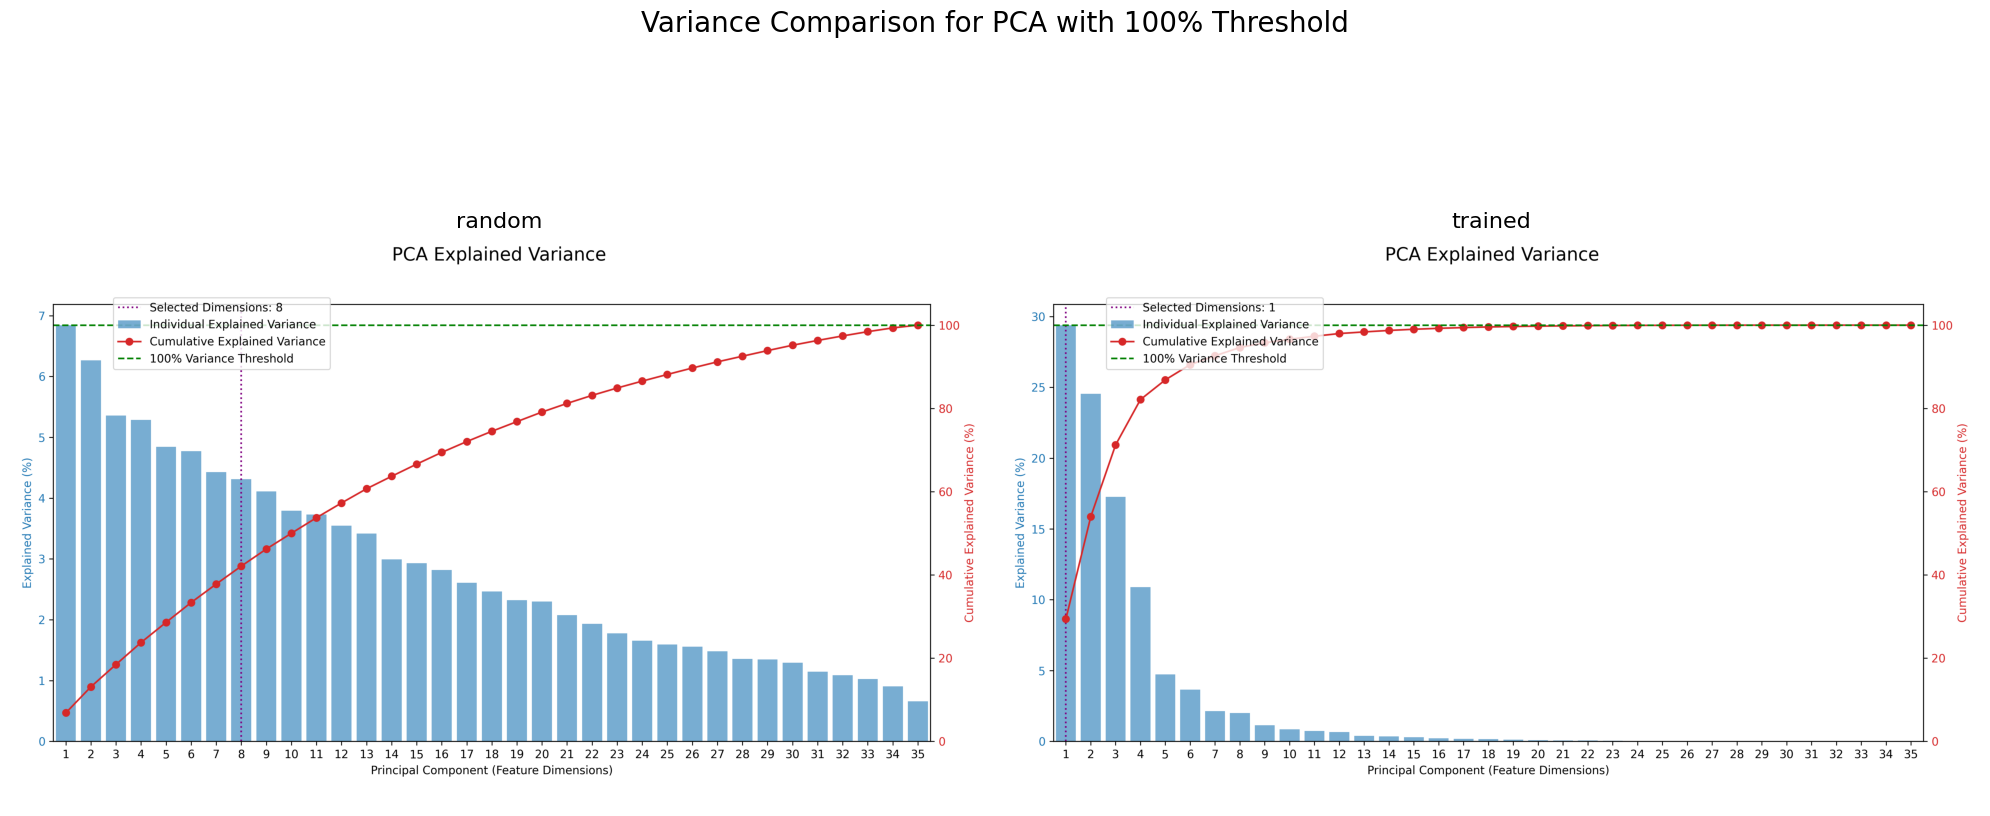

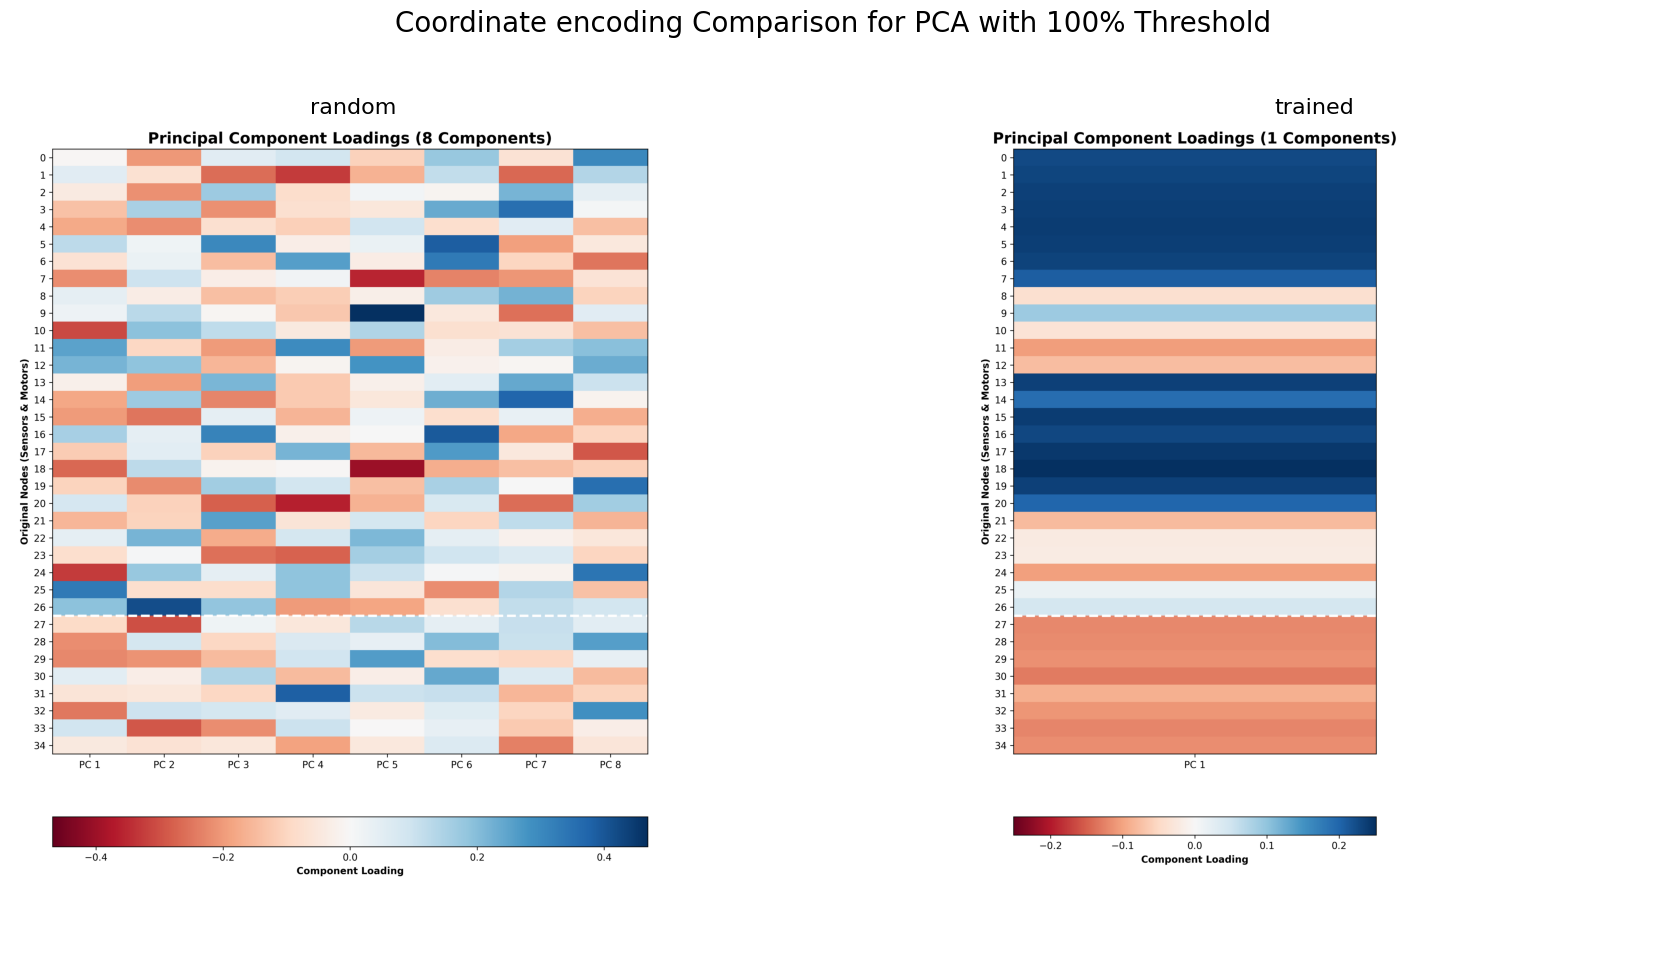

In [ ]:
pca_variances = [config["data_analysis"]["variance_threshold"], 1.0]

for data_label, data_array in data_sources.items():
    for variance in pca_variances:
        percentage = int(variance*100)
        print(f"Analyzing {data_label} sampling data")
        analyzer_pca = PCAanalyzer(
            data=data_array, 
            obs_size=obs_size, 
            act_size=act_size,
            variance_threshold=variance, 
            max_dims=config["data_analysis"]["max_dims"](obs_size, act_size),
            hidden_depth=config["substrate"]["hidden_depth"]
        )
        input_coors, output_coors = analyzer_pca.generate_io_coordinates()
        analysis_io_coors[data_label][f"pca{percentage}"]["input_coors"] = input_coors
        analysis_io_coors[data_label][f"pca{percentage}"]["output_coors"] = output_coors
        analyzer_pca.plot_variance(save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_{data_label}.png")
        analyzer_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_{data_label}.png")
        print("\n")

for variance in pca_variances:
    percentage = int(variance*100)
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_random.png", f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_trained.png"],
        plot_titles=["random", "trained"],
        main_title=f"Variance Comparison for PCA with {percentage}% Threshold",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_comparison.png"
    )
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_random.png", f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_trained.png"],
        plot_titles=["random", "trained"],
        main_title=f"Coordinate encoding Comparison for PCA with {percentage}% Threshold",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_comparison.png"
)

### Factor Analysis

Next, the data is analysed through factor analysis.

Analyzing trained sampling data
Running Factor Analysis to find 8 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 9
Running Factor Analysis to find 8 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 9
Factor loadings heatmap saved to: output/ant/data_analysis/fa_heatmap_trained.png


Analyzing random sampling data
Running Factor Analysis to find 8 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 9
Running Factor Analysis to find 8 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 9
Factor loadings heatmap saved to: output/ant/data_analysis/fa_heatmap_random.png




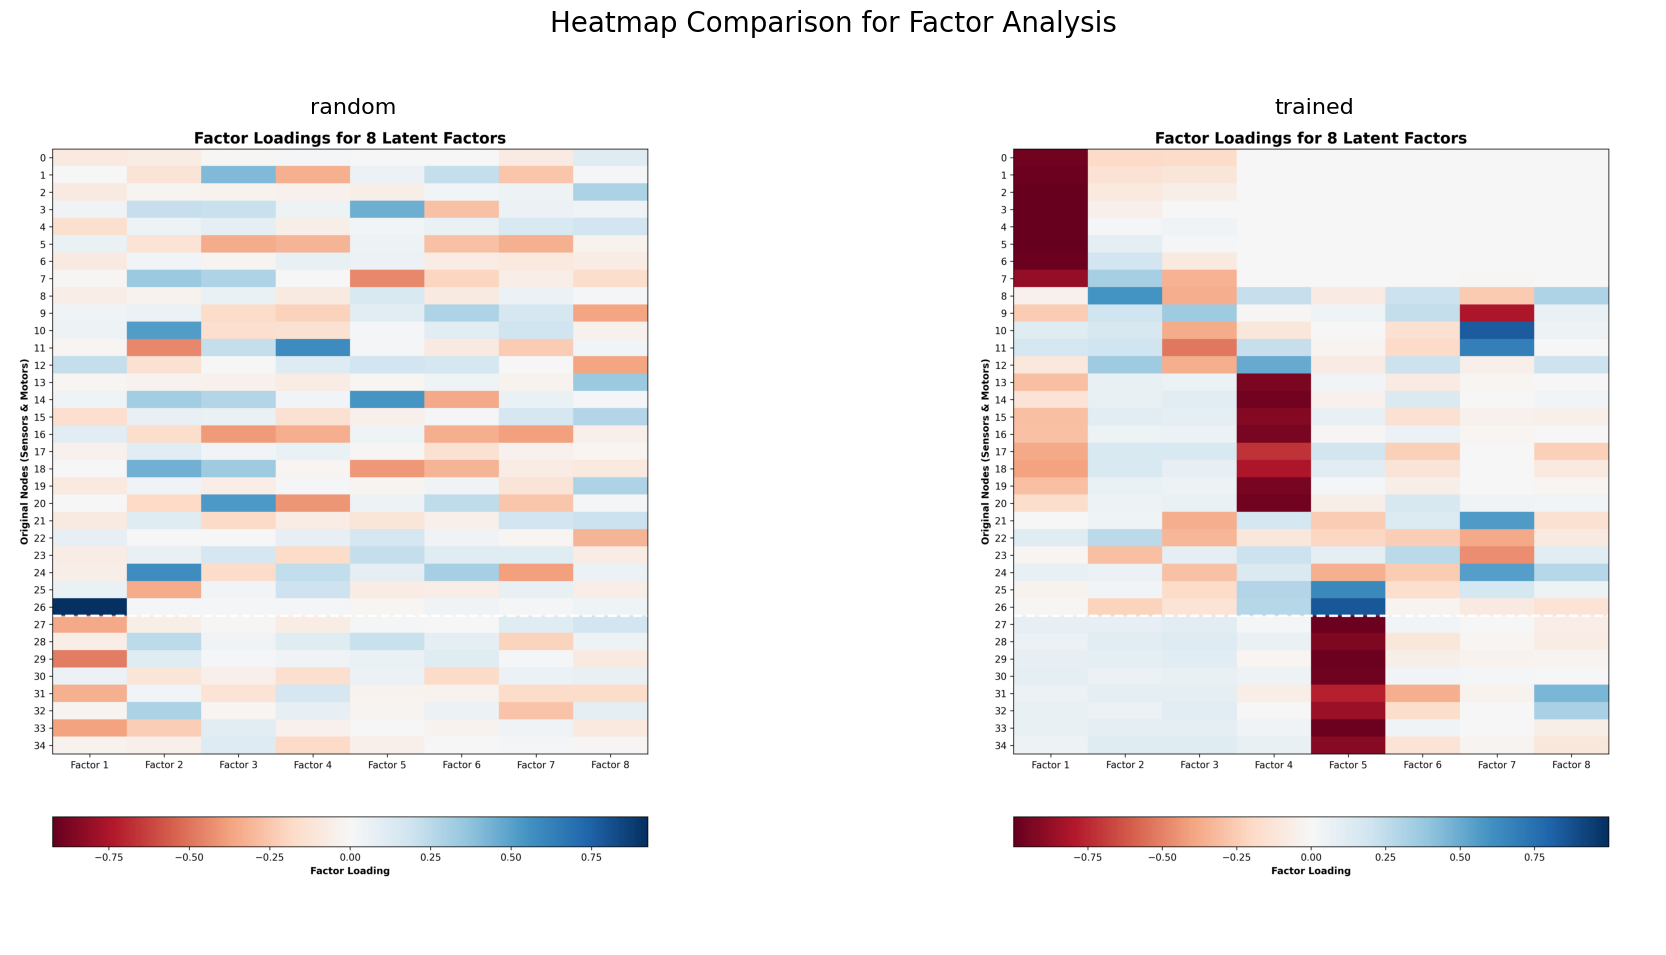

In [ ]:
for data_label, data_array in data_sources.items():
    print(f"Analyzing {data_label} sampling data")
    analyzer_fa = FactorAnalyzer(
        data=data_array, 
        obs_size=obs_size, 
        act_size=act_size,
        max_dims=config["data_analysis"]["max_dims"](obs_size, act_size),
        hidden_depth=config["substrate"]["hidden_depth"]
    )
    input_coors, output_coors = analyzer_fa.generate_io_coordinates()
    analysis_io_coors[data_label]["fa"]["input_coors"] = input_coors
    analysis_io_coors[data_label]["fa"]["output_coors"] = output_coors
    input_coors_fa, output_coors_fa = analyzer_fa.generate_io_coordinates()
    analyzer_fa.plot_factor_loadings(save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_{data_label}.png")
    print("\n")

display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/fa_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/fa_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Heatmap Comparison for Factor Analysis",
    save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_comparison.png"
)

### Sparse Dictionary Learning

Lastly, Sparse Dictionary Learning is also applied to the data.

Analyzing trained sampling data
Running Sparse Dictionary Learning to find 8 dictionary atoms...
SDL complete. Extracting coordinates (loadings on dictionary atoms).
Added layering dimension. Final coordinate size: 9
Dictionary atoms heatmap saved to: output/ant/data_analysis/sdl_heatmap_trained.png


Analyzing random sampling data
Running Sparse Dictionary Learning to find 8 dictionary atoms...
SDL complete. Extracting coordinates (loadings on dictionary atoms).
Added layering dimension. Final coordinate size: 9
Dictionary atoms heatmap saved to: output/ant/data_analysis/sdl_heatmap_random.png




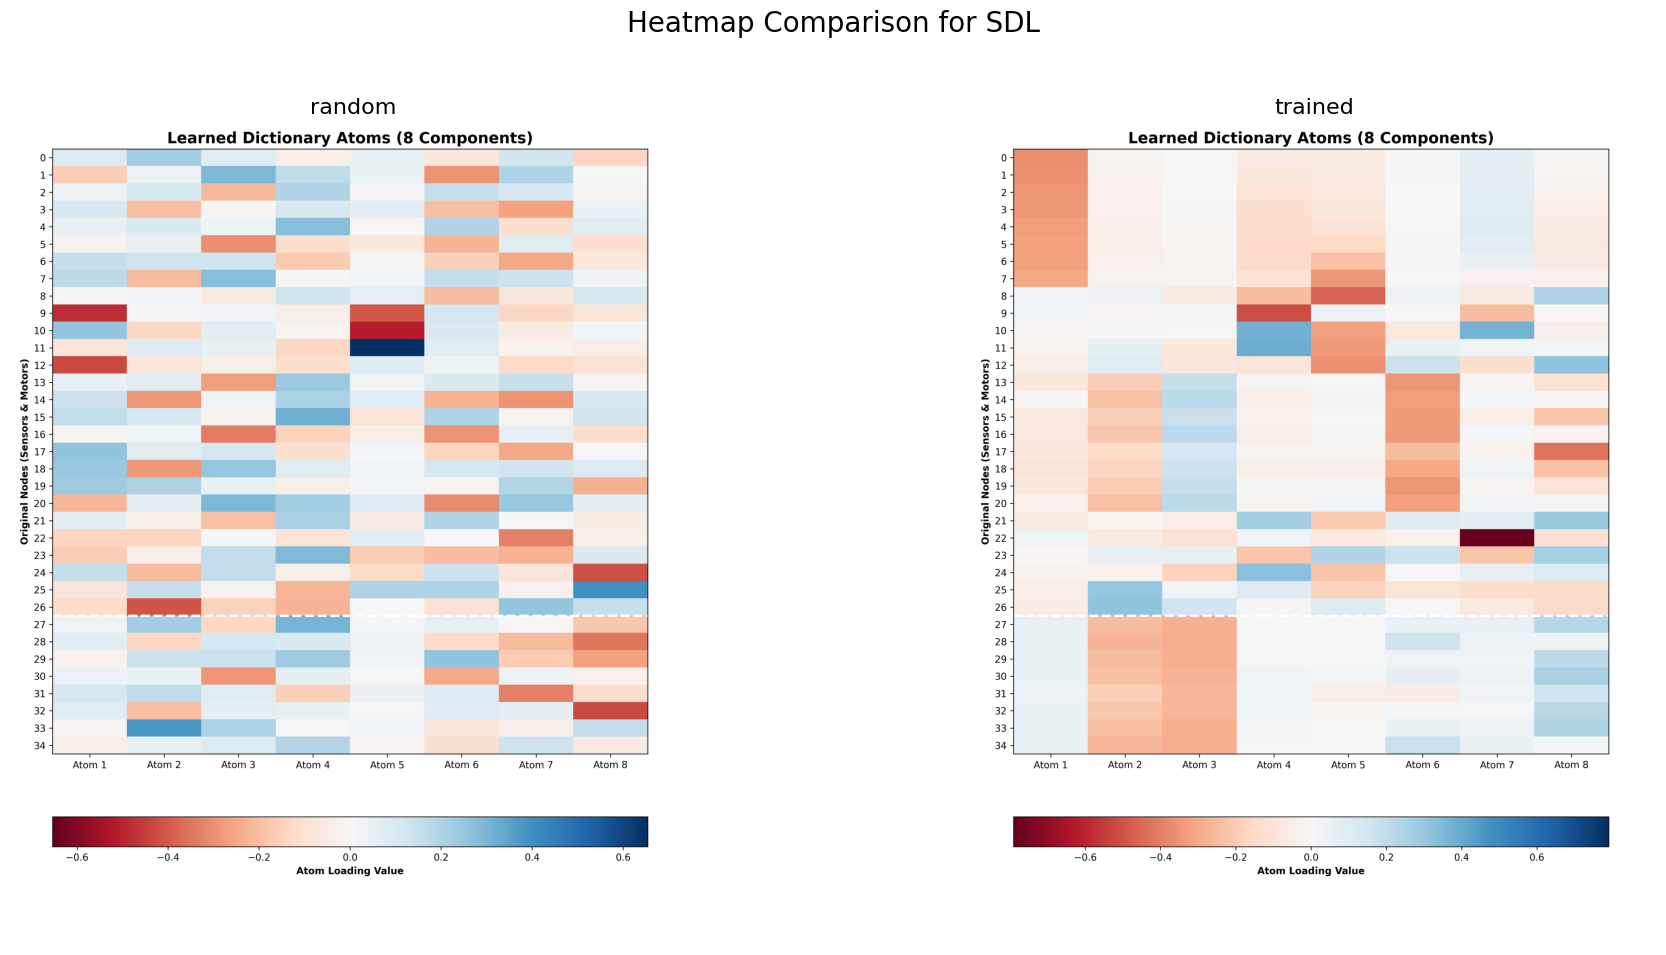

In [ ]:
for data_label, data_array in data_sources.items():
    print(f"Analyzing {data_label} sampling data")
    analyzer_sdl = SparseDictionaryAnalyzer(
        data=data_array,
        obs_size=obs_size,
        act_size=act_size,
        max_dims=config["data_analysis"]["max_dims"](obs_size, act_size),
        alpha=config["data_analysis"]["sdl_alpha"],
        max_iter=config["data_analysis"]["sdl_max_iter"],
        hidden_depth=config["substrate"]["hidden_depth"]
    )
    input_coors_sdl, output_coors_sdl = analyzer_sdl.generate_io_coordinates()
    analysis_io_coors[data_label]["sdl"]["input_coors"] = input_coors
    analysis_io_coors[data_label]["sdl"]["output_coors"] = output_coors
    analyzer_sdl.plot_dictionary_atoms(save_path=f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_{data_label}.png")
    print("\n")

display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Heatmap Comparison for SDL",
    save_path=f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_comparison.png"
)

## Substrate Generation

Now it's time to generate the full substrates. The input and ouput nodes have already been generated above, so the hidden layers are the crucial part that's missing.

### Generating Hidden Layers

A `HiddenLayerGenerator` class is used to generate hidden nodes from the input node. There are of course, many ways these hidden nodes can be defined in the high-dimensional space. The class has a few options hard-coded:

* `one_hot`: This does a one-hot encoding of the dimensions, so there will be one coordinate for each dimension. E.g. for 3 Dimensions: (1,0,0),(0,1,0),(0,0,1)
* `one_double_hot`: This is the same as one-hot, but has two coordinates in every dimension, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(2,0,0),(0,2,0),(0,0,2)
* `two_hot`: This adds all possible pairs of dimensions as coordinates to the one_hor ecoding, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(0,1,1)
* `shift`: This schema takes all input nodes and simply "shifts" every one of them into the layering direction by 1 for each layer.

One important thing to notice is that the number of generated hidden nodes is highly dependent on the number of dimensions (one_hot/one_double_hot linear and two_hot exponential), except for the `shift` method.

In [18]:
hidden_layer_gen = HiddenLayerGenerator(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
)

substrates = defaultdict(lambda: defaultdict(dict))

### Simple Baseline Substrate

Before the data-driven approchaes are applied, some baselines are needed. The first one is a very simple 2D grid. This is the basic baseline in the sense of a "vanilla" HyperNEAT algorithm.

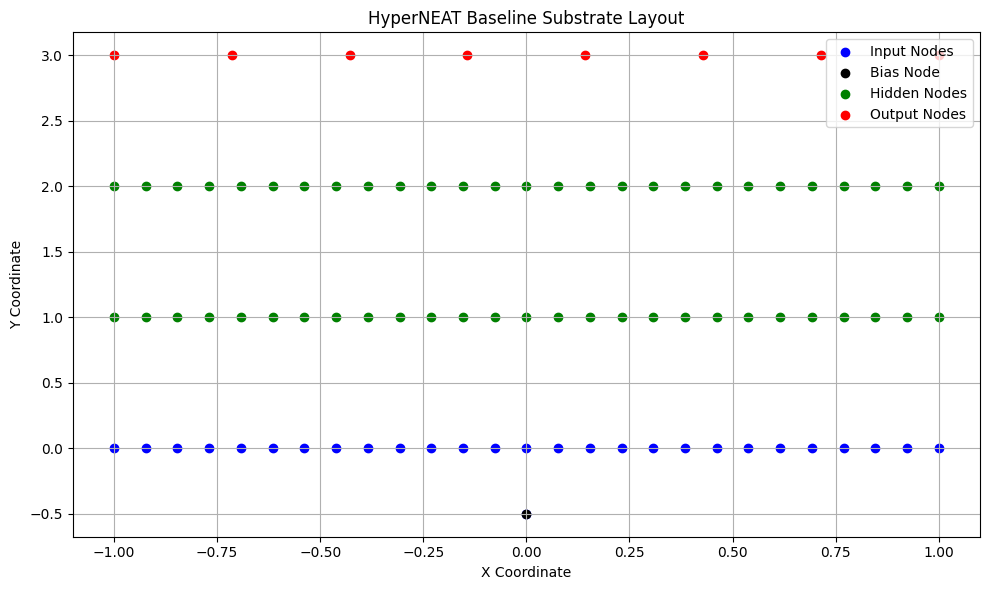

In [28]:
hidden_width_full = max(obs_size, act_size)
hidden_depth = config["substrate"]["hidden_depth"]

# Input neurons spaced horizontally from -1 to 1 at y = 0
input_coors_simple_wo_bias = [(i / (obs_size - 1) * 2 - 1, 0) for i in range(obs_size)]

# Bias node placed slightly below input layer for distinctiveness
bias_coor_simple = [(0, -0.5)]

# Hidden neurons spaced out evenly between input and output
hidden_coors_simple = [
    ((i / (hidden_width_full - 1) * 2 - 1), (j / max(1,(hidden_depth - 1)) * (hidden_depth - 1) + 1.0))
    for j in range(hidden_depth)
    for i in range(hidden_width_full)
]

# Output neurons spaced horizontally from -1 to 1 at y = 1
output_coors_simple = [(i / (act_size - 1) * 2 - 1, (hidden_depth+1)) for i in range(act_size)]

input_coors_simple = input_coors_simple_wo_bias + bias_coor_simple

substrates["manual"]["simple"]["substrate"] = FullSubstrate(
    input_coors=input_coors_simple,
    hidden_coors=hidden_coors_simple,
    output_coors=output_coors_simple,
)

substrates["manual"]["simple"]["input_coors"] = input_coors_simple
substrates["manual"]["simple"]["hidden_coors"] = hidden_coors_simple
substrates["manual"]["simple"]["output_coors"] = output_coors_simple

plt.figure(figsize=(10, 6))

# Plot each layer with different colors
x, y = zip(*input_coors_simple)
plt.scatter(x, y, c='blue', label='Input Nodes')
x, y = zip(*bias_coor_simple)
plt.scatter(x, y, c='black', label='Bias Node')
x, y = zip(*hidden_coors_simple)
plt.scatter(x, y, c='green', label='Hidden Nodes')
x, y = zip(*output_coors_simple)
plt.scatter(x, y, c='red', label='Output Nodes')

plt.title('HyperNEAT Baseline Substrate Layout')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/baseline_substrate")
plt.show()

### Substrate from Manual Mapping

The next baseline represents a substrate which is "hand-crafted" by a human expert.

A `ManualInputMapper` class creates substrate coordinates from a mapping of semantically meaningful categories such as "front", "back", "velocity", "angle". Every substrate node can be sorted into multiple categories. One of multiple categories form a dimension. E.g. "angle" might be a single dimension on its own whereas "front" and "back" are two opposite directions in the same dimension. Accordingly every category maps to a vector in the respective dimension. Applying all the vectors for a node, e.g. "front", "left", "hip" and "angular velocity" for the input node "angular velocity of the front left hip", generates the coordinate (0, 0, 1, 0, 0, 0, 0, -1, 1, 1, 0, 0).

The manual mappings are are implemented for the following [Brax environments](https://github.com/google/brax/tree/main/brax/envs):
* ant
* halfcheetah
* swimmer

In [ ]:
manual_mapper = ManualInputMapper(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
)
input_coors_manual, output_coors_manual = manual_mapper.generate_io_coordinates()
hidden_coors_manual = hidden_layer_gen.get_hidden_coors(input_coors=input_coors_manual)

substrates["manual"]["mapping"]["input_coors"] = input_coors_manual
substrates["manual"]["mapping"]["hidden_coors"] = hidden_coors_manual
substrates["manual"]["mapping"]["output_coors"] = output_coors_manual

substrates["manual"]["mapping"]["substrate"] = FullSubstrate(
    input_coors=input_coors_manual,
    hidden_coors=hidden_coors_manual,
    output_coors=output_coors_manual,
)

Using user-defined input and output mapping for 'ant'.
Number of feature dimensions: 10
Total number after adding output and layering dimensions (coord_size): 12
Number of input nodes (obs + bias): 28
Number of output nodes: 8


### Substrate from Data Analysis Results

Next, the input and output nodes created through data analysis are used to create substrates.

In [ ]:
for data_label, data_dict in analysis_io_coors.items():
    for method_label, method_dict in data_dict.items():

        input_coors = method_dict["input_coors"]
        output_coors = method_dict["output_coors"]
        hidden_coors = hidden_layer_gen.get_hidden_coors(input_coors=input_coors)
        analysis_io_coors[data_label][method_label]["hidden_coors"] = hidden_coors

        substrates[data_label][method_label]["substrate"] = FullSubstrate(
            input_coors=input_coors,
            hidden_coors=hidden_coors,
            output_coors=output_coors,
        )

        substrates[data_label][method_label]["input_coors"] = input_coors
        substrates[data_label][method_label]["hidden_coors"] = hidden_coors
        substrates[data_label][method_label]["output_coors"] = output_coors

        # all input and output coordinates are logged for further analysis
        log_coors = method_dict["input_coors"]
        for coor in method_dict["output_coors"]:
            log_coors.append(coor)
        save_coordinates_to_csv(
            coordinates=log_coors,
            filepath=f"{OUTPUT_DIR}/coordinates/{data_label}_{method_label}_io.csv",
        )

Successfully saved coordinates to: output/ant/coordinates/trained_pca75_io.csv
Successfully saved coordinates to: output/ant/coordinates/trained_pca100_io.csv
Successfully saved coordinates to: output/ant/coordinates/trained_fa_io.csv
Successfully saved coordinates to: output/ant/coordinates/trained_sdl_io.csv
Successfully saved coordinates to: output/ant/coordinates/random_pca75_io.csv
Successfully saved coordinates to: output/ant/coordinates/random_pca100_io.csv
Successfully saved coordinates to: output/ant/coordinates/random_fa_io.csv
Successfully saved coordinates to: output/ant/coordinates/random_sdl_io.csv


## Neuroevolution

Finally the substrates are ready to be used for neuroevolution. 


In [ ]:
for data_label, data_dict in substrates.items():
    for method_label, method_dict in data_dict.items():

        active_substrate = substrates[data_label][method_label]["substrate"]
        evol_algorithm = create_evol_algorithm(substrate=active_substrate)

        wanbd_name = f"{env_name}_{data_label}_{method_label}"
        wandb_tags = [config["substrate"]["hidden_layer_type"], env_name, data_label, method_label]

        wandb.init(
            name=wanbd_name,
            project="connection_cost",
            tags=wandb_tags,
            config=config  
        )

        wandb.config.update({
            "substrate": {
                "obs_size": obs_size,
                "act_size": act_size,
                "substrate.query_coors.shape": active_substrate.query_coors.shape, # (num_queries, query_dim)
                "algorithm.num_inputs": evol_algorithm.num_inputs,
                }
            }
        )

        pipeline = CustomPipeline(
            algorithm=evol_algorithm,
            problem=env_problem,
            seed=config["experiment"]["seed"],
            generation_limit=config["evolution"]["generation_limit"],
            fitness_target=config["evolution"]["fitness_target"],
            is_save=False,
            save_dir=config["experiment"]["output_dir"],
        )

        init_state = pipeline.setup()
        state = pipeline.auto_run(state=init_state)

        print(f"\nTraining finished. Best fitness achieved: {pipeline.best_fitness}")

        wandb.finish()

        state_for_show = state[0] if isinstance(state, tuple) else state

        # Transform the best genome into network parameters
        best_genome = pipeline.best_genome

        # Built-in show method to produce and save video
        pipeline.show(
            state=state_for_show,
            best=best_genome,
            output_type="mp4",
            save_path=f"{OUTPUT_DIR}/video/agent_{data_label}_{method_label}.mp4",
        )

        input_coors = substrates[data_label][method_label]["input_coors"]
        hidden_coors = substrates[data_label][method_label]["hidden_coors"]
        output_coors = substrates[data_label][method_label]["output_coors"]
        visualize_cppn(pipeline, state, f"{OUTPUT_DIR}/topology/cppn_{data_label}_{method_label}")
        visualize_nn(pipeline, state, f"{OUTPUT_DIR}/topology/nn_{data_label}_{method_label}", active_substrate, input_coors, hidden_coors, output_coors, config["substrate"]["hidden_depth"])


TypeError: 'FullSubstrate' object is not subscriptable